## Model 1: Best performing model
 - 56 x 75 x 3
 - mini_batch size = 256
 - 20 epochs
 - 16 layers

In [2]:
import keras
import tensorflow as tf
import PIL
import os, shutil
import numpy as np

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import os
from os import listdir
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


> Below is the code to call the training and validation data from their respective directories. 

In [7]:
base_directory = "../skin-cancer-mnist-ham10000"

train_directory = os.path.join(base_directory, 'image_data_train')
validation_directory = os.path.join(base_directory, 'image_data_validation')
aug_train_directory = os.path.join(base_directory, 'image_data_train_augmented')

aug_train_type0 = os.path.join(aug_train_directory, 'type_0')
aug_train_type1 = os.path.join(aug_train_directory, 'type_1')
aug_train_type2 = os.path.join(aug_train_directory, 'type_2')
aug_train_type3 = os.path.join(aug_train_directory, 'type_3')
aug_train_type4 = os.path.join(aug_train_directory, 'type_4')
aug_train_type5 = os.path.join(aug_train_directory, 'type_5')
aug_train_type6 = os.path.join(aug_train_directory, 'type_6')


val_type0 = os.path.join(validation_directory, 'type_0')
val_type1 = os.path.join(validation_directory, 'type_1')
val_type2 = os.path.join(validation_directory, 'type_2')
val_type3 = os.path.join(validation_directory, 'type_3')
val_type4 = os.path.join(validation_directory, 'type_4')
val_type5 = os.path.join(validation_directory, 'type_5')
val_type6 = os.path.join(validation_directory, 'type_6')

In [8]:
for i in [aug_train_type0,aug_train_type1,aug_train_type2,aug_train_type3,aug_train_type4,aug_train_type5,aug_train_type6]:
    print(f"{i}: {len(listdir(i))}")

#the total number of augmented images for each class in the training set

../skin-cancer-mnist-ham10000/image_data_train_augmented/type_0: 3575
../skin-cancer-mnist-ham10000/image_data_train_augmented/type_1: 3804
../skin-cancer-mnist-ham10000/image_data_train_augmented/type_2: 4298
../skin-cancer-mnist-ham10000/image_data_train_augmented/type_3: 3419
../skin-cancer-mnist-ham10000/image_data_train_augmented/type_4: 3352
../skin-cancer-mnist-ham10000/image_data_train_augmented/type_5: 3471
../skin-cancer-mnist-ham10000/image_data_train_augmented/type_6: 4354


> Below is the instantiation and building of a sequential CNN made of 16 layers. Dropout is included to reduce overfitting. Padding was changed to same to try to improve accuracy for pictures that may have details near the edge of the image.

In [10]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding = "same", input_shape=(56, 75, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = "same", input_shape=(56, 75, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding = "same"))
model.add(Conv2D(32, (3, 3), activation='relu', padding = "same"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding = "same"))
model.add(Conv2D(32, (3, 3), activation='relu', padding = "same"))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
# model.add(Dropout(rate = 0.5))

model.add(Dense(512, activation='relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(256, activation='relu'))
# model.add(Dropout(rate = 0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(64, activation='relu'))

model.add(Dense(7, activation='softmax'))

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 56, 75, 64)        1792      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 37, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 37, 32)        18464     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 18, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 18, 32)        9248      
__________

> Below is the model compiled. The default learning rate is being used currently because I implemented the ReduceLROnPlateau method in the actual fitting of the model.

In [11]:
adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['acc'])

W0823 16:30:35.583678 4704986560 deprecation_wrapper.py:119] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0823 16:30:35.596829 4704986560 deprecation_wrapper.py:119] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

> Initially the batch size was set at the default 32, but after reading several articles on the effect of batch size, I increased it to 256 with good results.

In [13]:
train_generator = train_datagen.flow_from_directory(
        aug_train_directory,
        target_size=(56, 75), 
        batch_size= 256,
        class_mode='categorical' 
)

validation_generator = val_datagen.flow_from_directory(
        validation_directory,
        target_size=(56, 75),
        batch_size= 256,
        class_mode='categorical')

Found 26273 images belonging to 7 classes.
Found 2502 images belonging to 7 classes.


In [14]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (256, 56, 75, 3)
labels batch shape: (256, 7)


In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [EarlyStopping(monitor= "val_loss", patience = 5, restore_best_weights= True),
             ReduceLROnPlateau(monitor="loss", patience = 2)]


> Callbacks used are EarlyStopping and ReduceLROnPlateau. EarlyStopping ends the model when the val_loss has increased 5 epochs in a row and ReduceLROnPlateau lowers to the learning rate after two epochs where the training loss has not dropped.

> It was important that the steps per epoch be related to the batch size so that the model could see all of the data each epoch. It helped with the accuracy of the model. 

In [17]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=np.ceil(26273/256),
      epochs=20,
      validation_data=validation_generator,
      validation_steps= np.ceil(2502/256),
      callbacks= callbacks,
)

W0823 16:35:45.201938 4704986560 deprecation.py:323] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
103/103 [==============================] - 399s 4s/step - loss: 1.9316 - acc: 0.1652 - val_loss: 1.9012 - val_acc: 0.4984
Epoch 2/20
103/103 [==============================] - 394s 4s/step - loss: 1.8422 - acc: 0.2217 - val_loss: 1.4638 - val_acc: 0.5643
Epoch 3/20
103/103 [==============================] - 403s 4s/step - loss: 1.6140 - acc: 0.3098 - val_loss: 1.5403 - val_acc: 0.5028
Epoch 4/20
103/103 [==============================] - 397s 4s/step - loss: 1.4323 - acc: 0.4025 - val_loss: 1.7180 - val_acc: 0.3921
Epoch 5/20
103/103 [==============================] - 366s 4s/step - loss: 1.3118 - acc: 0.4508 - val_loss: 1.2841 - val_acc: 0.5496
Epoch 6/20
103/103 [==============================] - 368s 4s/step - loss: 1.2218 - acc: 0.4906 - val_loss: 1.0845 - val_acc: 0.6011
Epoch 7/20
103/103 [==============================] - 514s 5s/step - loss: 1.1502 - acc: 0.5203 - val_loss: 0.9791 - val_acc: 0.5991
Epoch 8/20
103/103 [==============================] - 509s 5s/step - 

In [21]:
model.save("model_1.h5")

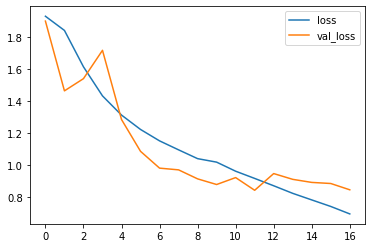

In [19]:
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend()
#Graph of Loss 

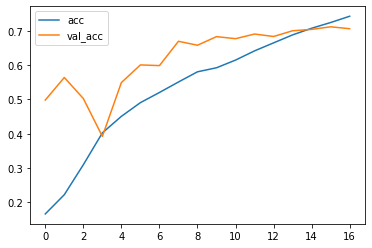

In [20]:
plt.plot(history.history["acc"], label = "acc")
plt.plot(history.history["val_acc"], label = "val_acc")
plt.legend();
#Graph of Accuracy

## Summary:

This model returned the highest training and validation accuracy. While the test accuracy did not reflect the validation accuracy, it was higher than any other model in this study. Two improvements that were made to the model were an increase in mini-batch size from 32 to 256 and a change to the number of steps within an epoch that was directly related to the mini-batch size. 